# Exercise 4

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [3]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    if use_cuda:
        torch.cuda.is_available()
        device = "cuda"
    else:
        device = "cpu"

    loss_fn = nn.NLLLoss()

    # TODO: set the model to train mode
    model.train()
    
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for idx, (x,y) in enumerate(train_loader):
        x.to(device)
        y.to(device)

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(x)
        
        # TODO: compute negative log likelihood loss
        batch_loss = loss_fn(output, y)
        
        # TODO: do backpropagation
        batch_loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if idx % log_interval == 0:
            print("Epoch: " + str(epoch) + " Loss: " + str(batch_loss.item()))
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [4]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet3"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [ ]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        super(FCNet1, self).__init__()#
        self.activation = nn.Sigmoid()
        self.linear1 = nn.Linear(784, 200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 60)
        self.linear4 = nn.Linear(60, 30)
        self.linear5 = nn.Linear(30, 10)
        self.softmax = nn.LogSoftmax(dim=1)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        # original shape: (64, 1, 28, 28) should be (64, 784)
        x = x.view(x.size(0), -1)  # Flattens each image while preserving batch size
        
        # TODO: run network layers
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = self.softmax(x)

        return output

In [24]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with relu non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        # TODO: initialize network layers
        super(FCNet2, self).__init__()#
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(784, 200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 60)
        self.linear4 = nn.Linear(60, 30)
        self.linear5 = nn.Linear(30, 10)
        self.softmax = nn.LogSoftmax(dim=1)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        # original shape: (64, 1, 28, 28) should be (64, 784)
        x = x.view(x.size(0), -1)  # Flattens each image while preserving batch size
        
        # TODO: run network layers
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = self.softmax(x)

        return output

In [26]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with relu non-linearity and batch normalisation
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        # TODO: initialize network layers
        super(FCNet3, self).__init__()#
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(784, 200)
        self.batchNorm1 = nn.BatchNorm1d(200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 60)
        self.batchNorm3 = nn.BatchNorm1d(60)
        self.linear4 = nn.Linear(60, 30)
        self.linear5 = nn.Linear(30, 10)
        self.softmax = nn.LogSoftmax(dim=1)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        # original shape: (64, 1, 28, 28) should be (64, 784)
        x = x.view(x.size(0), -1)  # Flattens each image while preserving batch size
        
        # TODO: run network layers
        x = self.linear1(x)
        x = self.batchNorm1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.batchNorm3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = self.softmax(x)

        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [7]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 1x28x28 -> 32x26x26
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)  # 32x26x26 -> 64x12x12
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # 64x12x12 -> 128
        self.fc2 = nn.Linear(128, 10)  # 128 -> 10
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        # TODO: compute log softmax over the output
        output = self.log_softmax(x)
        
        return output

In [9]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    with batch normalization in the first convolutional and first fully connected layer

    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 1x28x28 -> 32x26x26
        self.batchNorm2d = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)  # 32x26x26 -> 64x12x12
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # 64x12x12 -> 128
        self.fc2 = nn.Linear(128, 10)  # 128 -> 10
        self.relu = nn.ReLU()
        self.batchNorm1d = nn.BatchNorm1d(128)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.batchNorm2d(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.batchNorm1d(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        # TODO: compute log softmax over the output
        output = self.log_softmax(x)
        
        return output

In [15]:
class ConvNet3(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    with batch normalization in the first convolutional and first fully connected layer
    and max pooling to reduce dimension
    
    Dimensions:
    1x28x28->32x26x26->64x24x24->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet3, self).__init__()
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 1x28x28 -> 32x26x26
        self.batchNorm2d = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # 32x26x26 -> 64x24x24
        self.maxPool = nn.MaxPool2d(2)  # 64x24x24 -> 64x12x12
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # 64x12x12 -> 128
        self.fc2 = nn.Linear(128, 10)  # 128 -> 10
        self.relu = nn.ReLU()
        self.batchNorm1d = nn.BatchNorm1d(128)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.batchNorm2d(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxPool(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.batchNorm1d(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        # TODO: compute log softmax over the output
        output = self.log_softmax(x)
        
        return output

Epoch: 1 Loss: 2.267927646636963
Epoch: 1 Loss: 0.16948121786117554
Epoch: 1 Loss: 0.06037759408354759
Epoch: 1 Loss: 0.061213769018650055
Epoch: 1 Loss: 0.10498649626970291
Epoch: 1 Loss: 0.05969724804162979
Epoch: 1 Loss: 0.03707516938447952
Epoch: 1 Loss: 0.016990285366773605
Epoch: 1 Loss: 0.10929606854915619
Epoch: 1 Loss: 0.03580087423324585

Test set: Average loss: 0.0381, Accuracy: 9869/10000 (98.69%)



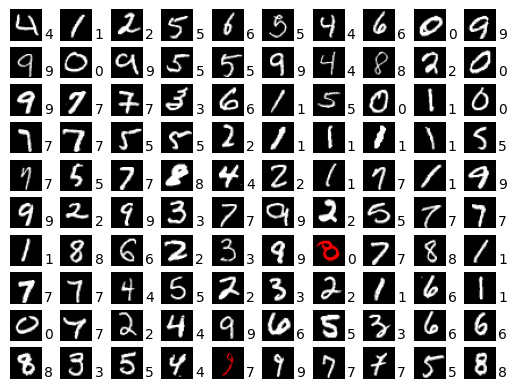

Epoch: 2 Loss: 0.05623798072338104
Epoch: 2 Loss: 0.015465756878256798
Epoch: 2 Loss: 0.006007419899106026
Epoch: 2 Loss: 0.014089170843362808
Epoch: 2 Loss: 0.006918659433722496
Epoch: 2 Loss: 0.005219746381044388
Epoch: 2 Loss: 0.06248315051198006
Epoch: 2 Loss: 0.0032613156363368034
Epoch: 2 Loss: 0.01364023145288229
Epoch: 2 Loss: 0.03428717702627182

Test set: Average loss: 0.0292, Accuracy: 9903/10000 (99.03%)



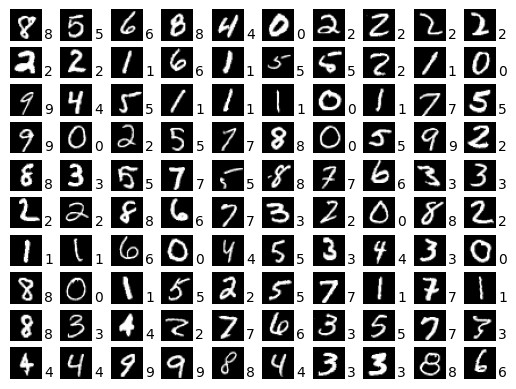

Epoch: 3 Loss: 0.014013681560754776
Epoch: 3 Loss: 0.0011004968546330929
Epoch: 3 Loss: 0.00468452088534832
Epoch: 3 Loss: 0.04297010228037834
Epoch: 3 Loss: 0.05733315646648407
Epoch: 3 Loss: 0.0016758749261498451
Epoch: 3 Loss: 0.0026280153542757034
Epoch: 3 Loss: 0.007344591896981001
Epoch: 3 Loss: 0.00763319805264473
Epoch: 3 Loss: 0.04252742975950241

Test set: Average loss: 0.0276, Accuracy: 9914/10000 (99.14%)



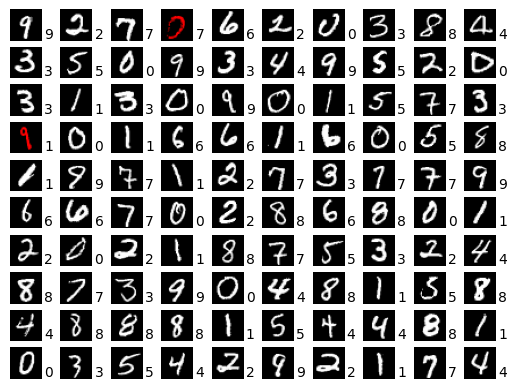

Epoch: 4 Loss: 0.0012991505209356546
Epoch: 4 Loss: 0.0018183451611548662
Epoch: 4 Loss: 0.0005216251593083143
Epoch: 4 Loss: 0.0013982043601572514
Epoch: 4 Loss: 0.004812693689018488
Epoch: 4 Loss: 0.0032835365273058414
Epoch: 4 Loss: 0.002194532658904791
Epoch: 4 Loss: 0.0050197928212583065
Epoch: 4 Loss: 0.0064429608173668385
Epoch: 4 Loss: 0.0071722958236932755

Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)



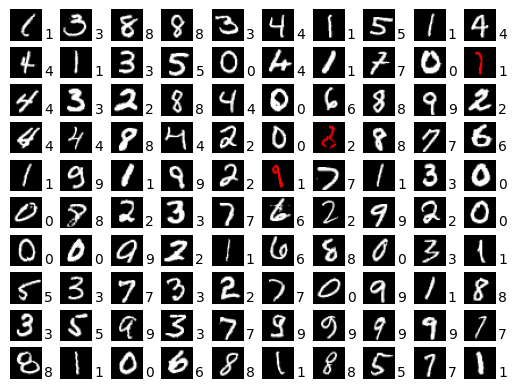

Epoch: 5 Loss: 0.0013222212437540293
Epoch: 5 Loss: 0.002748979954048991
Epoch: 5 Loss: 0.0005783183150924742
Epoch: 5 Loss: 0.001533973845653236
Epoch: 5 Loss: 0.0006832701619714499
Epoch: 5 Loss: 0.0005671095568686724
Epoch: 5 Loss: 0.0018536826828494668
Epoch: 5 Loss: 0.0043926420621573925
Epoch: 5 Loss: 0.001608187798410654
Epoch: 5 Loss: 0.0008316752500832081

Test set: Average loss: 0.0231, Accuracy: 9926/10000 (99.26%)



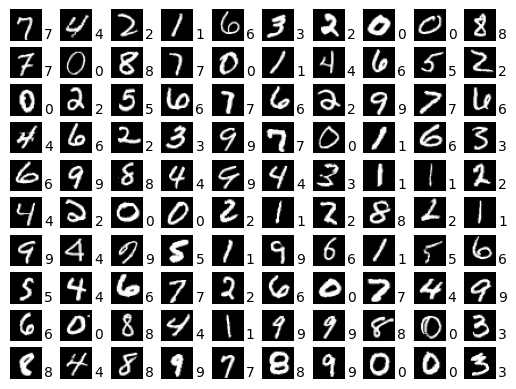

Epoch: 6 Loss: 0.0014754119329154491
Epoch: 6 Loss: 0.001676887390203774
Epoch: 6 Loss: 0.0032342723570764065
Epoch: 6 Loss: 0.001149832154624164
Epoch: 6 Loss: 0.0004929063725285232
Epoch: 6 Loss: 0.001015121815726161
Epoch: 6 Loss: 0.0009110267274081707
Epoch: 6 Loss: 0.0010060794884338975
Epoch: 6 Loss: 0.00013791477249469608
Epoch: 6 Loss: 0.0029325031209737062

Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)



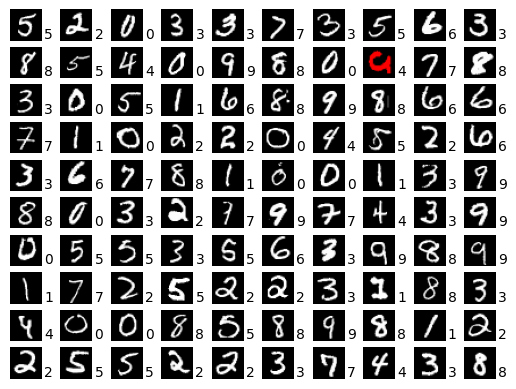

Epoch: 7 Loss: 0.000813014805316925
Epoch: 7 Loss: 0.013397658243775368
Epoch: 7 Loss: 0.004012159537523985
Epoch: 7 Loss: 0.0007663151482120156
Epoch: 7 Loss: 0.0008066469454206526
Epoch: 7 Loss: 0.000788139586802572
Epoch: 7 Loss: 0.0010822447948157787
Epoch: 7 Loss: 0.0006652501178905368
Epoch: 7 Loss: 0.0023791121784597635
Epoch: 7 Loss: 0.0016008876264095306

Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99.27%)



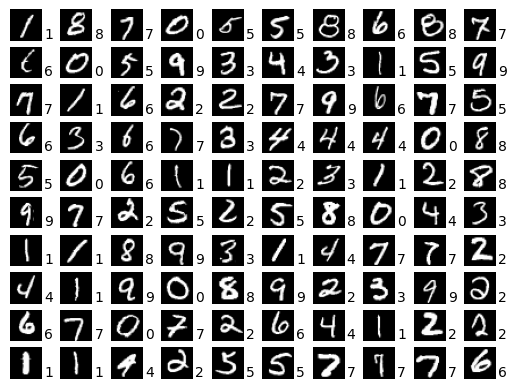

Epoch: 8 Loss: 0.000855692895129323
Epoch: 8 Loss: 0.00025454972637817264
Epoch: 8 Loss: 0.001366618787869811
Epoch: 8 Loss: 0.0005477350787259638
Epoch: 8 Loss: 0.0032861565705388784
Epoch: 8 Loss: 0.00042914674850180745
Epoch: 8 Loss: 0.0004929874558001757
Epoch: 8 Loss: 0.000678079086355865
Epoch: 8 Loss: 0.004155470058321953
Epoch: 8 Loss: 0.00022438190353568643

Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)



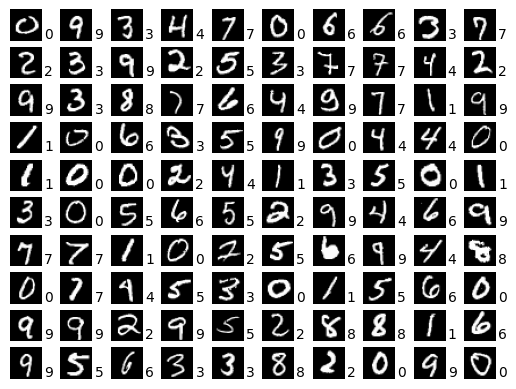

Epoch: 9 Loss: 0.00017246119386982173
Epoch: 9 Loss: 0.0003859397256746888
Epoch: 9 Loss: 0.0036800375673919916
Epoch: 9 Loss: 0.0015700195217505097
Epoch: 9 Loss: 4.258636909071356e-05
Epoch: 9 Loss: 0.0004648436151910573
Epoch: 9 Loss: 0.00028959306655451655
Epoch: 9 Loss: 0.005730112548917532
Epoch: 9 Loss: 0.0010348729556426406
Epoch: 9 Loss: 0.000985771999694407

Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)



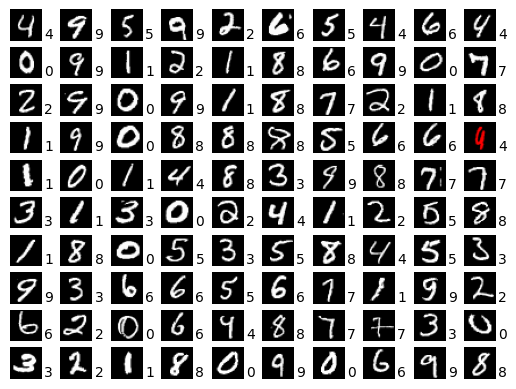

Epoch: 10 Loss: 0.004783913493156433
Epoch: 10 Loss: 0.0004883817746303976
Epoch: 10 Loss: 0.0004317828279454261
Epoch: 10 Loss: 0.0016157672507688403
Epoch: 10 Loss: 0.0010375850833952427
Epoch: 10 Loss: 0.0039733657613396645
Epoch: 10 Loss: 0.000532815232872963
Epoch: 10 Loss: 0.0005531327333301306
Epoch: 10 Loss: 0.001636407570913434
Epoch: 10 Loss: 0.00047766324132680893

Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)



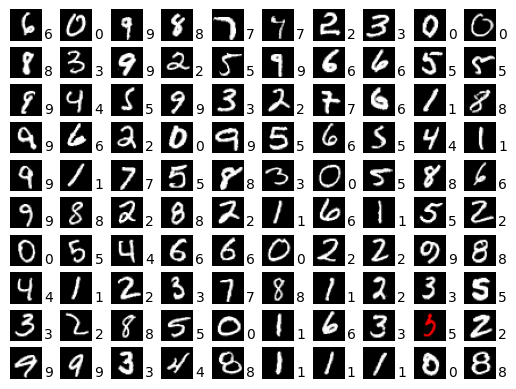

In [16]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")